In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [2]:

from qiskit_aer import Aer, AerSimulator

In [3]:
import math as m
import cmath as cm

In [5]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1

In [6]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state

In [7]:
def fsim(theta,phi,beta):  #Block for free fermions
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_full(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')




    
def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

In [8]:
## We will first form the floquet unitary block, and get the unitary circuit matrix

def floquet_unitary_block(N,theta,theta_k,theta_z):
    qc = QuantumCircuit(2*N + 1)
    num_qubits = 2*N + 1
    c = num_qubits//2

    add_fsim_half(qc,theta)
    qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
    add_fsim_inv_half(qc,theta)

    qc.save_unitary()

    simulator = Aer.get_backend('aer_simulator')
    circ = transpile(qc, simulator)

    result = simulator.run(circ).result()
    unitary = result.get_unitary(circ)
    print("Circuit unitary:\n", np.asarray(unitary).round(5))
    return np.asarray(unitary)

    
    

In [14]:
##Let us test it out with N = 2,6, theta = pi/4, theta_k = pi/6, theta_z = -pi/6

N = 2
theta = 1.07
theta_k = 0.79
theta_z = 0.5*np.sqrt(2)*(np.sqrt(2) - 1)*np.pi*np.sin(theta)



In [21]:
sv1 = fermi_state(N)
imp_state = Statevector.from_label('1')
sv2 = fermi_state(N)

#Tensor these statevectors
sv = sv1.tensor(imp_state).tensor(sv2)
sv_np = np.array(sv)

print(sv_np)

[0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]


In [11]:
import scipy

In [16]:
unitary = floquet_unitary_block(N,theta,theta_k,theta_z)

Circuit unitary:
 [[ 1.     +0.j       0.     +0.j       0.     +0.j      ...
   0.     +0.j       0.     +0.j       0.     +0.j     ]
 [ 0.     +0.j      -0.47714+0.30218j  0.1654 +0.80849j ...
   0.     +0.j       0.     +0.j       0.     +0.j     ]
 [ 0.     +0.j       0.1654 +0.80849j -0.55748-0.09053j ...
   0.     +0.j       0.     +0.j       0.     +0.j     ]
 ...
 [ 0.     +0.j       0.     +0.j       0.     +0.j      ...
  -0.55748-0.09053j  0.1654 +0.80849j  0.     +0.j     ]
 [ 0.     +0.j       0.     +0.j       0.     +0.j      ...
   0.1654 +0.80849j -0.47714+0.30218j  0.     +0.j     ]
 [ 0.     +0.j       0.     +0.j       0.     +0.j      ...
   0.     +0.j       0.     +0.j       1.     +0.j     ]]


In [17]:
herm_mat = -1j*scipy.linalg.logm(unitary)
eigvals,eigvecs = np.linalg.eigh(herm_mat)

In [26]:
print(eigvecs[:,0])

[ 0.00000000e+00+0.00000000e+00j -7.79717507e-18+0.00000000e+00j
 -1.20872006e-17+1.98477077e-17j  8.87424445e-17+1.02348685e-16j
 -4.11893901e-17+1.56125113e-17j -1.72413236e-14-1.00939575e-14j
  2.16184573e-14+1.26031220e-14j  1.48125292e-18+8.98767580e-17j
 -2.14972960e-14-1.24598728e-14j  1.41691767e-16+1.25527056e-16j
  1.06017102e-16+2.57642626e-16j -1.75640158e-01-4.80206770e-01j
  4.18378189e-01-1.68695071e-02j -1.24262546e-15+2.60941019e-16j
 -1.03186012e-15+2.25972918e-16j  2.79132709e-14-1.94265767e-14j
  1.70310860e-14+9.76722108e-15j  2.62892772e-16+4.56028056e-16j
 -1.83512211e-16+2.18060113e-16j  2.23402962e-01+6.10792065e-01j
 -3.28930335e-01+1.32628631e-02j -1.16384185e-15-1.85181422e-16j
 -1.54384133e-15+5.96059154e-16j -3.49204940e-14+2.45800198e-14j
 -4.50429218e-16+2.95317907e-16j  3.46510419e-14-2.47389046e-14j
 -2.73815933e-14+1.97870143e-14j  7.88860905e-31-2.46519033e-31j
  1.77493704e-30+3.16997021e-32j -1.11342914e-01-8.54681857e-02j
  8.75381726e-02+6.719537

In [13]:
def coeffs_calc(sv,eigvecs):
    coeffs = []
    for i in range(len(eigvecs)):
        coeffs.append(np.dot(np.conjugate(eigvecs[:,i]),sv))
    return coeffs

def time_evolved_state(eigvals,eigvecs,coeffs,t):
    time_state = 0
    for i in range(len(coeffs)):
        time_state += coeffs[i]*np.exp(-1j*eigvals[i]*t)*eigvecs[:,i]
    return time_state

In [27]:
## Let us check if the coeffs work

coeffs = coeffs_calc(sv_np,eigvecs)
sv_test = 0

for i in range(len(coeffs)):
    sv_test += coeffs[i]*eigvecs[:,i]

print(np.linalg.norm(sv_test - sv_np))

1.7385128361183756e-15


In [28]:
def sz_operator(N):
    eye1 = np.eye(2**N)
    z_op = np.array([[1,0],[0,-1]])
    eye2 = np.eye(2**N)

    z_imp = np.kron(eye1,z_op)
    z_imp = np.kron(z_imp,eye2)

    return z_imp

def plot_Sz(N,eigvals,eigvecs,coeffs,time_steps):
    sz_op = sz_operator(N)
    sz_exp = [0]*time_steps
    for t in range(time_steps):
        time_state = time_evolved_state(eigvals,eigvecs,coeffs,t)
        sz_exp[t] = np.dot(np.conjugate(time_state),np.dot(sz_op,time_state))
    
    return sz_exp


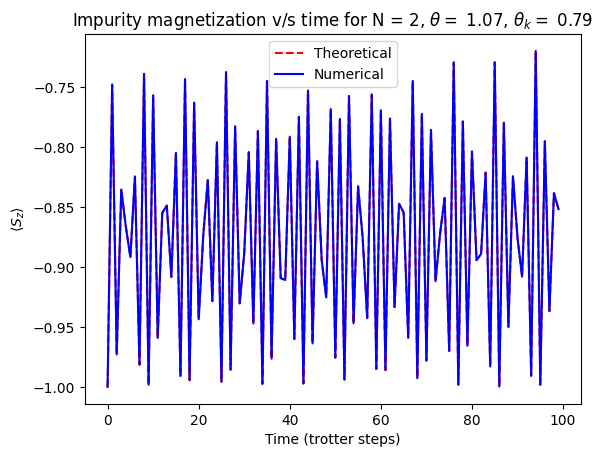

In [31]:
sz_vals = []

sz_exp = plot_Sz(N,eigvals,eigvecs,coeffs,100)

data = np.loadtxt(f"../scaled_codes/N = 2, theta = {theta}, theta_k = {theta_k}, t = 100_sz_tol.txt")[:,1]

plt.plot(range(100),data,"r--",label = "Theoretical")
plt.plot(range(100),data,"b-",label = "Numerical")
plt.xlabel('Time (trotter steps)')
plt.ylabel(r"$\langle S_z \rangle$")
plt.legend()
plt.title(f"Impurity magnetization v/s time for N = {N}," + r" $\theta =$" + f" {theta}, " + r"$\theta_k =$" +f" {theta_k}")
plt.show()

In [13]:
print(unitary.shape)
print(np.count_nonzero(unitary))

(8192, 8192)
1639328


In [14]:
## let us see how quick it is to find eigenvalues for this unitary matrix

eigenvalues = np.linalg.eigvals(unitary)
print(eigenvalues) #Are these sorted?

[-0.83719969+0.54689732j -0.63045854+0.77622293j  0.64279752-0.76603613j
 ...  1.        +0.j          0.92299656+0.38480819j
  1.        +0.j        ]


In [18]:
herm_eigvals = 1j*np.log(eigenvalues)
herm_eigvals = np.sort(herm_eigvals.real)
print(herm_eigvals)

[-3.14122039 -3.14122039 -3.14122039 ...  3.13659405  3.13659405
  3.13659405]
